In [1]:
# import packages
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import sklearn
import os
import glob
from datetime import date

## Read input

### ABUD. Family aggr. Part filtr.

In [2]:
# read ABUD part data
bgi = pd.read_excel('results/aggregation/abud/Family_BGI_merged_output_part.xlsx')
ill = pd.read_excel('results/aggregation/abud/Family_Illumina_merged_output_part.xlsx')

In [35]:
# aggrregation level
agg_level = 'family'

# define samples names
col_names = bgi.columns[1:]
samples = [name[4:] for name in col_names]

# new df with columns: name, bgi_sample_number, ill_sample_nember, correlation
df = pd.DataFrame(columns=['name', 'bgi_sample_number', 'ill_sample_number', 
                           'abud_corr','common','only_bgi','only_ill', 'only_bgi_names', 'only_ill_names'])

for smpl in samples:

    # if smpl present in both datasets
    col_name1 = 'ill_' + str(smpl)
    if col_name1 in ill.columns:

        col_name2 = 'bgi_' + str(smpl)
        if col_name2 in bgi.columns:
            
            #print(smpl)
            #read info about sample
            smplB = bgi[[agg_level, 'bgi_' + str(smpl)]].dropna()
            smplB = smplB[smplB['bgi_' + str(smpl)] > 0]  
            smplI = ill[[agg_level,'ill_' + str(smpl)]].dropna()
            smplI = smplI[smplI['ill_' + str(smpl)] > 0]

            mrg = pd.merge(smplB, smplI, on=agg_level, how='outer')
            #print(mrg['bgi_' + str(smpl)].corr(mrg['ill_' + str(smpl)]))
            #print('BGI nmb:' + str(len(smplB)) + ' Illumina nmb:' + str(len(smplI)))
            common_values = len(list(set(smplB[agg_level]).intersection(set(smplI[agg_level]))))
            only_bgi_gr = smplB.loc[~smplB[agg_level].isin(smplI[agg_level])]
            only_ill_gr = smplI.loc[~smplI[agg_level].isin(smplB[agg_level])]
            only_bgi_numb = len(only_bgi_gr)
            only_ill_numb = len(only_ill_gr)
            only_bgi_name = ','.join(map(str, only_bgi_gr[agg_level].values))
            only_ill_name = ','.join(map(str, only_ill_gr[agg_level].values))

            # assign values to df
            df = df.append({'name': smpl, 'bgi_sample_number': len(smplB), 'ill_sample_number': len(smplI), 
                            'abud_corr': mrg['bgi_' + str(smpl)].corr(mrg['ill_' + str(smpl)]),
                            'common': common_values,'only_bgi': only_bgi_numb,'only_ill': only_ill_numb,
                            'only_bgi_names': only_bgi_name, 'only_ill_names': only_ill_name}, 
                            ignore_index=True)

df = df.sort_values(by=['common'], ascending=False)
df.to_excel('results/KrakenRes_abud_famAggr_part.xlsx', index=False)
df.head()

/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_53350/1120320552.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'name': smpl, 'bgi_sample_number': len(smplB), 'ill_sample_number': len(smplI),
/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_53350/1120320552.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'name': smpl, 'bgi_sample_number': len(smplB), 'ill_sample_number': len(smplI),
/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_53350/1120320552.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'name': smpl, 'bgi_sample_number': len(smplB), 'ill_sample_number': len(smplI),
/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel

,name,bgi_sample_number,ill_sample_number,abud_corr,common,only_bgi,only_ill,only_bgi_names,only_ill_names
122,VMB23G,15,15,0.999253,15,0,0,,
1192,V8M1K2,16,16,0.999368,15,1,1,UBA11471,CAG-313
1627,V1M14M,16,15,0.999823,15,1,0,Gastranaerophilaceae,
1393,VJR62K,16,17,0.994144,15,1,2,UBA660,"CAG-312,UBA1829"
1439,V6SZC7,15,15,0.999972,15,0,0,,


## RAD
### MAIN idea: compare the differences between cross-platform and intra-platform sequencing results

**Comparison of Species/Family Counts:**  
Compare the sp_number for BGI and Illumina across samples.  
This will give you an idea of how many species each method is detecting per sample.  
You could use statistical tests (like paired t-tests) to see if the differences are significant.

In [4]:
from scipy.stats import ttest_rel

# Load your dataset
df = pd.read_excel('results/KrakenRes_abud_famAggr_part_m.xlsx')

# Extract the species counts for each method
sp_counts_method1 = df['bgi_sample_number']
sp_counts_method2 = df['ill_sample_number']

# Performing a paired t-test
t_stat, p_value = ttest_rel(sp_counts_method1, sp_counts_method2)

print("T-statistic:", t_stat)
print("P-value:", p_value)

# Interpreting the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("The difference in species counts between the two methods is statistically significant.")
else:
    print("No significant difference in species counts between the two methods.")


T-statistic: 4.2090113198240084
P-value: 2.6791106376805386e-05
The difference in species counts between the two methods is statistically significant.


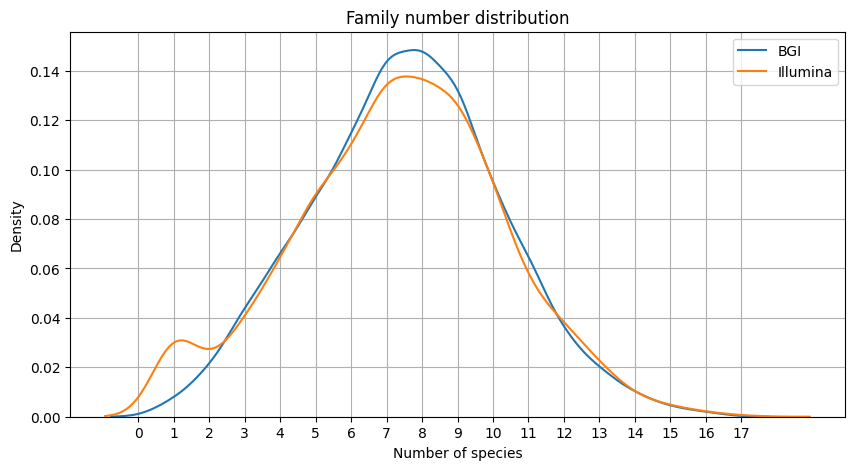

In [42]:
# plot sp number destribution for two methods
plt.figure(figsize=(10, 5))
sns.kdeplot(sp_counts_method1, bw_adjust=1, label='BGI')
sns.kdeplot(sp_counts_method2, bw_adjust=1, label='Illumina')
plt.xticks(range(0, 18, 1))
plt.grid(True)
plt.xlabel('Number of species')
plt.ylabel('Density')
plt.title('Family number distribution')
plt.legend()
plt.savefig('results/1_FamilyCounts_destr.png', dpi=300)

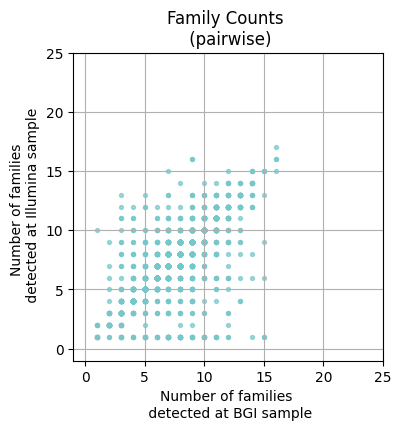

In [43]:
plt.figure(figsize=(4,4))
plt.scatter(df['bgi_sample_number'], df['ill_sample_number'], color='#75c7c9', alpha=0.7, s=8)
plt.xlabel('Number of families \n detected at BGI sample')
plt.ylabel('Number of families \n detected at Illumina sample')
plt.xlim(-1, 25)
plt.ylim(-1, 25)
plt.title('Family Counts \n (pairwise)')
plt.grid(True)

plt.savefig('results/1_FamilyCounts_pairwise.png', dpi=300, bbox_inches='tight')

**Correlation Analysis:**  
Utilize the 'correlation of abundance for the overlapping sp' column to assess how similarly the two methods are quantifying the species they both detect.  
High correlation would suggest similar quantification, while low correlation would indicate discrepancies.

In [ ]:
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient
correlation_coef, p_value = pearsonr(abundance_method1, abundance_method2)
print("Pearson Correlation Coefficient:", correlation_coef)
print("P-value:", p_value)

In [17]:
bgi.head()

,family,bgi_VNN89Q,bgi_VNIDA4,bgi_V4O7YS,bgi_VPEB3X,bgi_VJ1AZM,bgi_VAEQ34,bgi_VR8E19,bgi_V2VJWP,bgi_VMJVUD,...,bgi_VFZ765,bgi_VI7GET,bgi_VYYIUL,bgi_VC7BF0,bgi_VNJOCX,bgi_V7H80T,bgi_VNFOKA,bgi_VF64R7,bgi_VBSSCF,bgi_VE0WMY
0,Acidaminococcaceae,0.0,0.00000,0.00000,0.0000,0.00000,0.0,0.0,0.0000,0.00000,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0000,0.00000,0.00000,0.06060
1,Acutalibacteraceae,0.0,0.00000,2.95724,2.2022,0.00000,0.0,0.0,0.0000,0.02198,...,0.00000,0.0,0.0,0.0,0.00000,0.0,1.5414,1.56871,0.00000,1.31836
2,Akkermansiaceae,0.0,0.00000,0.00000,0.0000,0.00000,0.0,0.0,1.8178,0.00000,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0000,0.00000,0.00000,0.67771
3,Anaeroplasmataceae,0.0,0.03279,0.00000,0.0000,0.03315,0.0,0.0,0.0000,0.00000,...,0.03789,0.0,0.0,0.0,0.07527,0.0,0.0000,0.00000,0.03654,0.00000
4,Anaerotignaceae,0.0,0.00000,0.00000,0.0000,0.00000,0.0,0.0,0.0000,0.00000,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0000,0.00000,0.00000,0.00000


In [26]:
# melt bgi df 
bgi_melt = pd.melt(bgi, id_vars=['family'], var_name='sample', value_name='abundance')
# remove 'bgi_' from sample names
bgi_melt['sample'] = bgi_melt['sample'].str[4:]
bgi_melt['fam_smpl']  = bgi_melt['family'] + '_' + bgi_melt['sample']
bgi_melt = bgi_melt[['fam_smpl', 'abundance']]
bgi_melt = bgi_melt[bgi_melt['abundance'] > 0]
bgi_melt.columns = ['fam_smpl', 'abundance_bgi']
bgi_melt

# melt ill df
ill_melt = pd.melt(ill, id_vars=['family'], var_name='sample', value_name='abundance')
# remove 'ill_' from sample names
ill_melt['sample'] = ill_melt['sample'].str[4:]
ill_melt['fam_smpl']  = ill_melt['family'] + '_' + ill_melt['sample']
ill_melt = ill_melt[['fam_smpl', 'abundance']]
ill_melt = ill_melt[ill_melt['abundance'] > 0]
ill_melt.columns = ['fam_smpl', 'abundance_ill']
ill_melt

mrg = pd.merge(bgi_melt, ill_melt, on='fam_smpl', how='outer')
mrg = mrg.fillna(0)
#mrg['abundance_ill'] = mrg['abundance_ill'].astype(int)
#mrg['abundance_bgi'] = mrg['abundance_bgi'].astype(int)
mrg

,fam_smpl,abundance_bgi,abundance_ill
0,Bacteroidaceae_VNN89Q,20.63170,15.30152
1,CAG-239_VNN89Q,0.53910,0.46602
2,CAG-272_VNN89Q,0.17446,0.00000
3,CAG-288_VNN89Q,0.05316,0.10668
4,CAG-465_VNN89Q,0.87350,1.80050
...,...,...,...
17084,Gastranaerophilaceae_VRO6RY,0.00000,7.61301
17085,UBA932_V8L9OK,0.00000,13.90389
17086,CAG-74_V9V2LZ,0.00000,0.19532
17087,UBA932_V9V2LZ,0.00000,0.31740


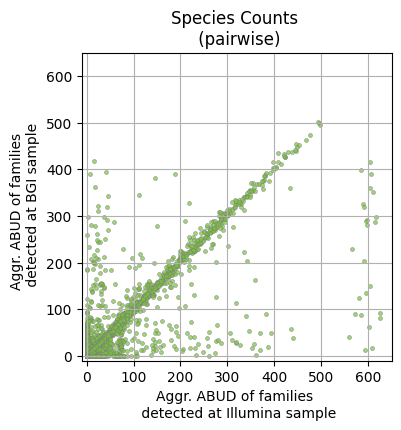

In [38]:
plt.figure(figsize=(4,4))
plt.scatter(mrg['abundance_ill'], mrg['abundance_bgi'], color='#75c733', alpha=0.7, s=8, edgecolors='grey', linewidths=0.5)
plt.xlabel('Aggr. ABUD of families \n detected at Illumina sample')
plt.ylabel('Aggr. ABUD of families  \n detected at BGI sample')
plt.xlim(-10, 650)
plt.ylim(-10, 650)
plt.title('Species Counts \n (pairwise)')
plt.grid(True)

plt.savefig('results/2_Correlatio_ABUDfamilies.png', dpi=300, bbox_inches='tight')

In [34]:
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient
correlation_coef, p_value = pearsonr(mrg['abundance_ill'], mrg['abundance_bgi'])
print("Pearson Correlation Coefficient:", correlation_coef)
print("P-value:", p_value)

# Interpreting the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("The difference in species counts between the two methods is statistically significant.")
else:
    print("No significant difference in species counts between the two methods.")

Pearson Correlation Coefficient: 0.8502301439182265
P-value: 0.0
The difference in species counts between the two methods is statistically significant.


**Common Species Analysis:**  
Analyze the 'common species detected by both methods' to see which species are consistently detected by both methods.  
This can be informative about the reliability and sensitivity of the methods.

In [49]:
# Filter for families with abundance > 0 in both methods
mrg_comm = mrg[(mrg['abundance_ill'] > 0) & (mrg['abundance_bgi'] > 0)].copy()

# Extract the family name from 'fam_smpl' column
# Assuming 'fam_smpl' is a column with family and sample information
mrg_comm['fam'] = mrg_comm['fam_smpl'].str.split('_').str[0]

# Get unique family names
comm_fam = mrg_comm['fam'].unique()

# Printing first few unique families for verification
print(comm_fam[:81])


['Bacteroidaceae' 'CAG-239' 'CAG-288' 'CAG-465' 'Lachnospiraceae'
 'Rikenellaceae' 'Tannerellaceae' 'Anaeroplasmataceae' 'Barnesiellaceae'
 'Muribaculaceae' 'Oscillospiraceae' 'UBA1829' 'UBA660' 'Victivallaceae'
 'Acutalibacteraceae' 'Burkholderiaceae' 'CAG-272' 'CAG-312' 'CAG-74'
 'CAG-826' 'CAG-917' 'CAG-977' 'Gastranaerophilaceae' 'Ruminococcaceae'
 'Succinivibrionaceae' 'UBA932' 'Dialisteraceae' 'Marinifilaceae'
 'Akkermansiaceae' 'Enterobacteriaceae' 'Borkfalkiaceae' 'CAG-314'
 'CAG-313' 'Elusimicrobiaceae' 'UBA1242' 'CAG-508' 'CAG-138'
 'Acidaminococcaceae' 'Treponemataceae' 'CAG-698' 'Pumilibacteraceae'
 'UBA11471' 'Coprobacteraceae' 'QALW01' 'Lactobacillaceae'
 'Bifidobacteriaceae' 'Desulfovibrionaceae' 'UBA1820' 'Paludibacteraceae'
 'Sphaerochaetaceae' 'Fusobacteriaceae' 'CAG-274' 'Selenomonadaceae'
 'UBA1067' 'Rs-D84' 'UBA4248' 'Anaerotignaceae' 'Streptomycetaceae'
 'UBA955' 'Peptostreptococcaceae' 'UBA1234' 'CAG-449' 'DTU072'
 'Butyricicoccaceae' 'F082' 'Streptococcaceae' 'C

**Exclusive Species Detection:**  
Look into 'sp number detected only by method1' and 'sp number detected only by method2' to understand which method is detecting unique species that the other method is missing. This could be critical for understanding the scope and limitations of each method.

In [50]:
# Filter for families with abundance > 0 in both methods
mrg_ex = mrg[(mrg['abundance_ill'] == 0) | (mrg['abundance_bgi'] == 0)].copy()

# Extract the family name from 'fam_smpl' column
# Assuming 'fam_smpl' is a column with family and sample information
mrg_ex['fam'] = mrg_ex['fam_smpl'].str.split('_').str[0]

# Get unique family names
ex_fam = mrg_ex['fam'].unique()

# Printing first few unique families for verification
print(ex_fam[:81])

['CAG-272' 'Dialisteraceae' 'CAG-508' 'Beijerinckiaceae' 'Ruminococcaceae'
 'Burkholderiaceae' 'CAG-314' 'Lachnospiraceae' 'Marinifilaceae'
 'Muribaculaceae' 'UBA932' 'Barnesiellaceae' 'Rikenellaceae'
 'Tannerellaceae' 'Anaeroplasmataceae' 'CAG-239' 'Enterobacteriaceae'
 'CAG-288' 'CAG-312' 'CAG-917' 'Gastranaerophilaceae' 'CAG-138'
 'Acutalibacteraceae' 'UBA660' 'Succinivibrionaceae' 'Megasphaeraceae'
 'CAG-74' 'Acidaminococcaceae' 'Oscillospiraceae' 'Anaerovoracaceae'
 'Bacteroidaceae' 'Pumilibacteraceae' 'Victivallaceae' 'UBA1242' 'CAG-313'
 'CAG-382' 'UBA955' 'Streptococcaceae' 'Akkermansiaceae' 'UBA1829'
 'UBA11471' 'Streptomycetaceae' 'Elusimicrobiaceae' 'Bifidobacteriaceae'
 'CAG-977' 'UBA1820' 'Borkfalkiaceae' 'Paludibacteraceae' 'CAG-826'
 'Rs-D84' 'Coprobacteraceae' 'Anaerotignaceae' 'Coprobacillaceae'
 'Desulfovibrionaceae' 'Clostridiaceae' 'Monoglobaceae' 'RUG14156'
 'Erysipelotrichaceae' 'Pasteurellaceae' 'CAG-449' 'QALW01'
 'Veillonellaceae' 'Helicobacteraceae' 'Chitinoph

In [55]:
# overlap comm and ex
overlap = list(set(comm_fam).intersection(set(ex_fam)))
print(len(overlap))

# only comm
only_comm = list(set(comm_fam) - set(overlap))
print("Only comm:")
print(only_comm)

# only ex
only_ex = list(set(ex_fam) - set(overlap))
print("Only ex:")
print(only_ex)

70
Only comm:
['UBA1407', 'Treponemataceae', 'CAG-465', 'Campylobacteraceae', 'Butyricicoccaceae', 'Synergistaceae', 'UBA1234', 'Sphaerochaetaceae', 'P3', 'CAG-274', 'Selenomonadaceae']
Only ex:
['UMGS1810', 'Dethiosulfovibrionaceae', 'Helicobacteraceae', 'UBA953', 'UBA1381', 'UBA3637', 'Beijerinckiaceae', 'Veillonellaceae', 'Megasphaeraceae', 'CAG-631', 'CAG-382']


**Qualitative Analysis of Exclusive Species:**  
Assess the 'sp name detected only by method1' and 'sp name detected only by method2'.  
Are there certain types of species that one method detects but the other does not?  
This could point to methodological biases or strengths.

In [63]:
# Filter for families with abundance present in BGI only
mrg_bgi_only = mrg[(mrg['abundance_ill'] == 0) & (mrg['abundance_bgi'] > 0)].copy()
mrg_bgi_only['fam'] = mrg_bgi_only['fam_smpl'].str.split('_').str[0]
bgi_only_fam = mrg_bgi_only['fam'].unique()

# Filter for families with abundance present in Illumina only
mrg_ill_only = mrg[(mrg['abundance_ill'] > 0) & (mrg['abundance_bgi'] == 0)].copy()
mrg_ill_only['fam'] = mrg_ill_only['fam_smpl'].str.split('_').str[0]
ill_only_fam = mrg_ill_only['fam'].unique()

# find overlap
overlap2 = list(set(bgi_only_fam).intersection(set(ill_only_fam)))
only_B = list(set(bgi_only_fam) - set(overlap2))
only_I = list(set(ill_only_fam) - set(overlap2))



In [67]:
only_B

['Anaerovoracaceae',
 'Beijerinckiaceae',
 'CAG-631',
 'Clostridiaceae',
 'Coprobacillaceae',
 'F082',
 'Fusobacteriaceae',
 'Helicobacteraceae',
 'Monoglobaceae',
 'Paludibacteraceae',
 'Pasteurellaceae',
 'RUG14156',
 'Rhodocyclaceae',
 'Rs-D84',
 'UBA1255',
 'UBA3637',
 'UBA955']

In [69]:
only_I

['CAG-698',
 'DTU072',
 'Dethiosulfovibrionaceae',
 'Lactobacillaceae',
 'Peptostreptococcaceae',
 'UBA4248',
 'UBA953',
 'UMGS1810']

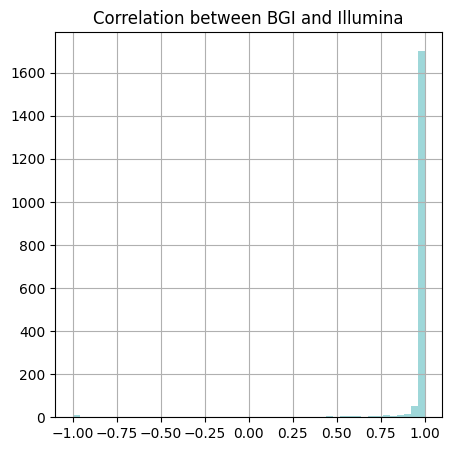

In [36]:
df['abud_corr'].hist(bins=50, figsize=(5,5), color='#75c7c9', alpha=0.7)
plt.title('Correlation between BGI and Illumina')

#plt.text(-1,-100, 'Scr: 2023_Illumina_vs_BGI > step2_Reads_annotation_comparison_KRAKEN', color='grey', fontsize=5)
#plt.text(-1,-120, 'Data: '+str(date.today()), color='grey', fontsize=5)

plt.savefig('results/Correlation_hist_abud_famAggr_part.png', dpi=300, bbox_inches='tight')

In [39]:
s1 = sum((df['bgi_sample_number'] > df['ill_sample_number']))
s2 = sum((df['ill_sample_number'] > df['bgi_sample_number']))

print(s1, s2)


528 528


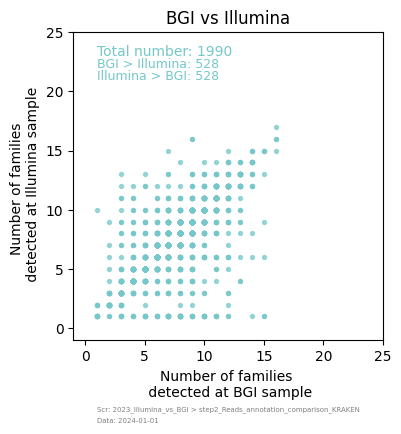

In [47]:
plt.figure(figsize=(4,4))
plt.scatter(df['bgi_sample_number'], df['ill_sample_number'], color='#75c7c9', alpha=0.7, s=8)
plt.xlabel('Number of families \n detected at BGI sample')
plt.ylabel('Number of families \n detected at Illumina sample')
plt.xlim(-1, 25)
plt.ylim(-1, 25)
plt.title('BGI vs Illumina')
plt.text(1,23, 'Total number: '+str(len(df)), color='#75c7c9')
plt.text(1,22, 'BGI > Illumina: '+str(sum((df['bgi_sample_number'] > df['ill_sample_number']))), fontsize=9, color='#75c7c9')
plt.text(1,21, 'Illumina > BGI: '+str(sum((df['ill_sample_number'] > df['bgi_sample_number']))), fontsize=9, color='#75c7c9')

plt.text(1,-7, 'Scr: 2023_Illumina_vs_BGI > step2_Reads_annotation_comparison_KRAKEN', color='grey', fontsize=5)
plt.text(1,-8, 'Data: '+str(date.today()), color='grey', fontsize=5)

plt.savefig('results/FamalyNumber_comp_abud_famAggr_part.png', dpi=300, bbox_inches='tight')

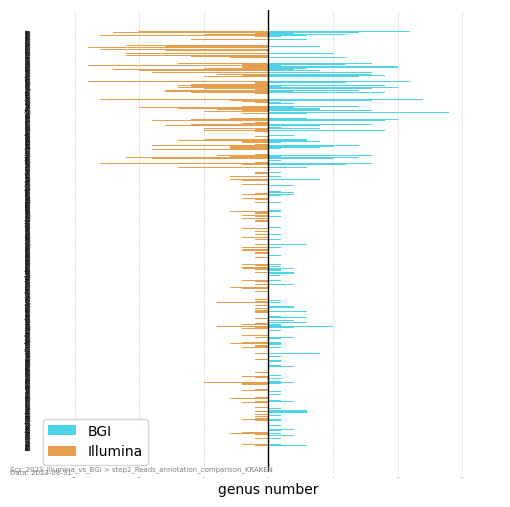

In [13]:
# Set the figure size
plt.figure(figsize=(6, 6))

# Plot the positive values as blue bars
plt.barh(df['name'], df['only_bgi_genus'], color='#4ed4e6', label='BGI')
plt.barh(df['name'], df['only_ill_genus']*-1, color='#e69f4e', label='Illumina')

# Set the x-axis limit to accommodate both positive and negative values
plt.xlim(-max(max(df['only_bgi_genus']), abs(min(df['only_ill_genus']))) - 2,
         max(max(df['only_bgi_genus']), abs(min(df['only_ill_genus']))) + 2)

# Add a vertical line at 0 to separate positive and negative values
plt.axvline(x=0, color='black', linewidth=1)

# Add labels and a title
plt.xlabel('genus number')
#plt.title('Bidirectional Bar Chart')
plt.legend()
plt.tick_params(axis='both', which='both', length=0, labelsize=0)
plt.box(False)
plt.grid(axis='x', linestyle='dotted', linewidth=0.5)

plt.text(-20,-100, 'Scr: 2023_Illumina_vs_BGI > step2_Reads_annotation_comparison_KRAKEN', color='grey', fontsize=5)
plt.text(-20,-120, 'Data: '+str(date.today()), color='grey', fontsize=5)

# Show the plot
plt.savefig('results/Genus_bar_ch1.png')
plt.savefig('results/Genus_bar_ch1.svg')


/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_8345/3286832855.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['only_bgi_genus'], shade=True, color='y')
/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_8345/3286832855.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['only_ill_genus'], shade=True, color='g', alpha=0.1)


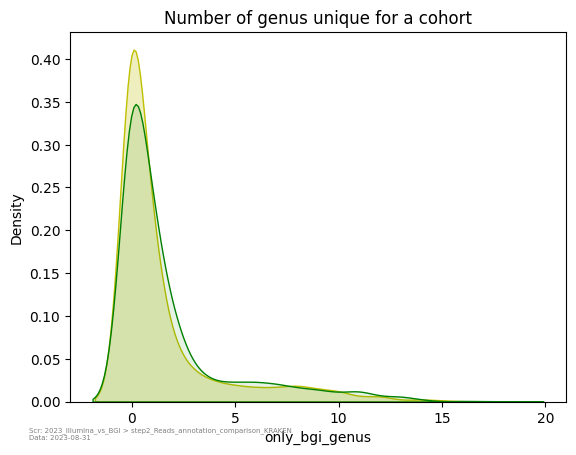

In [19]:
sns.kdeplot(df['only_bgi_genus'], shade=True, color='y')
sns.kdeplot(df['only_ill_genus'], shade=True, color='g', alpha=0.1)

plt.title('Number of genus unique for a cohort')

plt.text(-5,-0.035, 'Scr: 2023_Illumina_vs_BGI > step2_Reads_annotation_comparison_KRAKEN', color='grey', fontsize=5)
plt.text(-5,-0.045, 'Data: '+str(date.today()), color='grey', fontsize=5)

# Show the plot
plt.savefig('results/Genus_bar_ch2.png')
plt.savefig('results/Genus_bar_ch2.svg')